# Player Overall Prediction using FIFA 19 dataset

## Regression 

#### FIFA 19 is a soccer simulation video game developed by EA Sports, released in 2019 as part of the long-running FIFA series. The game simulates various aspects of football, including player movements, tactics, and management. It features thousands of real-life players from various football clubs and national teams, each with their own unique attributes and skill ratings.

#### A dataset associated with FIFA 19 consists of detailed information about the players featured in the game, such as their in-game attributes, personal information, and overall ratings. 

## List of import statements 

In [33]:
import json
import os
import csv
import collections
import numpy as np
import pandas as pd
import shutil
import time
import io
import requests

from scipy.stats import zscore
from scipy import stats
from sklearn import preprocessing
from sklearn import utils
import sklearn.feature_extraction.text as sk_text
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import  linear_model
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix, classification_report, r2_score, roc_curve, auc
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [34]:
# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, collections.Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32, np.object):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=0, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low


## Data read and pre-processing

In [13]:
df = pd.read_csv('./data.csv')

#### We will not be using the columns which contain images and logos, removing such columns below - 

In [14]:
df.drop(['Unnamed: 0','Photo','Flag','Club Logo'],axis=1,inplace=True)

#### filling the missing value for the continous variables.

In [15]:
df['ShortPassing'].fillna(df['ShortPassing'].mean(), inplace = True)
df['Volleys'].fillna(df['Volleys'].mean(), inplace = True)
df['Dribbling'].fillna(df['Dribbling'].mean(), inplace = True)
df['Curve'].fillna(df['Curve'].mean(), inplace = True)
df['FKAccuracy'].fillna(df['FKAccuracy'], inplace = True)
df['LongPassing'].fillna(df['LongPassing'].mean(), inplace = True)
df['BallControl'].fillna(df['BallControl'].mean(), inplace = True)
df['HeadingAccuracy'].fillna(df['HeadingAccuracy'].mean(), inplace = True)
df['Finishing'].fillna(df['Finishing'].mean(), inplace = True)
df['Crossing'].fillna(df['Crossing'].mean(), inplace = True)
df['Weight'].fillna('200lbs', inplace = True)
df['Contract Valid Until'].fillna(2019, inplace = True)
df['Height'].fillna("5'11", inplace = True)
df['Loaned From'].fillna('None', inplace = True)
df['Joined'].fillna('Jul 1, 2018', inplace = True)
df['Jersey Number'].fillna(8, inplace = True)
df['Body Type'].fillna('Normal', inplace = True)
df['Position'].fillna('ST', inplace = True)
df['Club'].fillna('No Club', inplace = True)
df['Work Rate'].fillna('Medium/ Medium', inplace = True)
df['Skill Moves'].fillna(df['Skill Moves'].median(), inplace = True)
df['Weak Foot'].fillna(3, inplace = True)
df['Preferred Foot'].fillna('Right', inplace = True)
df['International Reputation'].fillna(1, inplace = True)
df['Wage'].fillna('€200K', inplace = True)

In [ ]:
df.dropna()

#### Z-score normalization 

Z-score normalization, also known as standardization or z-score scaling, is a technique used in data preprocessing to transform numerical features in a dataset to have a mean of 0 and a standard deviation of 1. The purpose of z-score normalization is to standardize the scale of different features, making them more easily comparable and improving the performance of certain machine learning algorithms that are sensitive to the scale of input features, such as gradient-based optimization methods, support vector machines, and k-nearest neighbors.

To perform z-score normalization, you calculate the z-score for each data point using the following formula:

z = (x - μ) / σ

where x is the original data point, μ is the mean of the feature, and σ is the standard deviation of the feature.


In [17]:
# Z-score normalization

encode_numeric_zscore(df, 'Potential')
encode_numeric_zscore(df, 'Crossing')
encode_numeric_zscore(df, 'Finishing')
encode_numeric_zscore(df, 'HeadingAccuracy')
encode_numeric_zscore(df, 'ShortPassing')
encode_numeric_zscore(df, 'Volleys')
encode_numeric_zscore(df, 'Dribbling')
encode_numeric_zscore(df, 'Curve')
encode_numeric_zscore(df, 'FKAccuracy')
encode_numeric_zscore(df, 'LongPassing')
encode_numeric_zscore(df, 'BallControl')
encode_numeric_zscore(df, 'Acceleration')
encode_numeric_zscore(df, 'SprintSpeed')
encode_numeric_zscore(df, 'Agility')
encode_numeric_zscore(df, 'Reactions')
encode_numeric_zscore(df, 'Balance')
encode_numeric_zscore(df, 'ShotPower')
encode_numeric_zscore(df, 'Jumping')
encode_numeric_zscore(df, 'Stamina')
encode_numeric_zscore(df, 'Strength')
encode_numeric_zscore(df, 'LongShots')
encode_numeric_zscore(df, 'Aggression')
encode_numeric_zscore(df, 'Interceptions')
encode_numeric_zscore(df, 'Positioning')
encode_numeric_zscore(df, 'Vision')
encode_numeric_zscore(df, 'Penalties')
encode_numeric_zscore(df, 'Composure')
encode_numeric_zscore(df, 'Marking')
encode_numeric_zscore(df, 'StandingTackle')
encode_numeric_zscore(df, 'SlidingTackle')
encode_numeric_zscore(df, 'GKDiving')
encode_numeric_zscore(df, 'GKHandling')
encode_numeric_zscore(df, 'GKKicking')
encode_numeric_zscore(df, 'GKPositioning')
encode_numeric_zscore(df, 'GKReflexes')


In [18]:
col = ['Age', 'Potential', 'Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration', 'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower', 'Jumping' ,'Stamina', 'Strength', 'LongShots', 'Aggression', 'Interceptions', 'Positioning' ,'Vision', 'Penalties', 'Composure', 'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes']

for x in col:
    encode_numeric_range(df,x)

#### Label Encoding 

Label encoding is a technique used in data preprocessing to convert categorical variables into numerical values. This transformation is necessary for many machine learning algorithms, as they can only handle numerical data. Label encoding assigns an integer value to each distinct category or class in the categorical variable.

In [19]:
#Label encoding

encode_text_index(df,'Preferred Foot')
encode_text_index(df,'Body Type')

array(['Akinfenwa', 'C. Ronaldo', 'Courtois', 'Lean', 'Messi', 'Neymar',
       'Normal', 'PLAYER_BODY_TYPE_25', 'Shaqiri', 'Stocky'], dtype=object)

In [20]:
df.columns

Index(['ID', 'Name', 'Age', 'Nationality', 'Overall', 'Potential', 'Club',
       'Value', 'Wage', 'Special', 'Preferred Foot',
       'International Reputation', 'Weak Foot', 'Skill Moves', 'Work Rate',
       'Body Type', 'Real Face', 'Position', 'Jersey Number', 'Joined',
       'Loaned From', 'Contract Valid Until', 'Height', 'Weight', 'LS', 'ST',
       'RS', 'LW', 'LF', 'CF', 'RF', 'RW', 'LAM', 'CAM', 'RAM', 'LM', 'LCM',
       'CM', 'RCM', 'RM', 'LWB', 'LDM', 'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB',
       'RCB', 'RB', 'Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing',
       'Volleys', 'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing',
       'BallControl', 'Acceleration', 'SprintSpeed', 'Agility', 'Reactions',
       'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots',
       'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties',
       'Composure', 'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving',
       'GKHandling', 'GKKicking

In [21]:
df.dropna(inplace = True)

In [22]:
col = ['Age', 'Potential', 'Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration', 'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower', 'Jumping' ,'Stamina', 'Strength', 'LongShots', 'Aggression', 'Interceptions', 'Positioning' ,'Vision', 'Penalties', 'Composure', 'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes']

for x in col:
    remove_outliers(df,x,3)

In [23]:
df_x = df[['Age','Potential', 'Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration', 'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower', 'Jumping' ,'Stamina', 'Strength', 'LongShots', 'Aggression', 'Interceptions', 'Positioning' ,'Vision', 'Penalties', 'Composure', 'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes', 'Preferred Foot', 'Body Type']].copy()

In [24]:
df_x

,Age,Potential,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,...,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Preferred Foot,Body Type
20,0.448276,0.872340,0.647727,0.698925,0.711111,0.953488,0.465116,0.817204,0.681818,0.714286,...,0.956044,0.923077,0.875000,0.044944,0.076923,0.133333,0.089888,0.129032,1,3
24,0.586207,0.872340,0.602273,0.333333,0.877778,0.604651,0.476744,0.580645,0.613636,0.307692,...,0.989011,1.000000,0.988636,0.022472,0.021978,0.011111,0.033708,0.021505,0,6
33,0.448276,0.851064,0.818182,0.924731,0.833333,0.813953,0.953488,0.806452,0.840909,0.780220,...,0.263736,0.252747,0.375000,0.056180,0.087912,0.155556,0.089888,0.086022,1,3
36,0.413793,0.851064,0.931818,0.903226,0.888889,0.906977,0.941860,0.892473,0.954545,0.923077,...,0.560440,0.582418,0.556818,0.157303,0.153846,0.111111,0.044944,0.053763,0,3
39,0.586207,0.851064,0.625000,0.387097,0.855556,0.848837,0.686047,0.623656,0.625000,0.670330,...,0.934066,0.956044,0.931818,0.089888,0.120879,0.044444,0.089888,0.096774,1,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18199,0.068966,0.446809,0.295455,0.311828,0.411111,0.511628,0.255814,0.451613,0.329545,0.307692,...,0.494505,0.516484,0.522727,0.067416,0.065934,0.088889,0.146067,0.150538,1,3
18202,0.103448,0.361702,0.329545,0.387097,0.400000,0.488372,0.244186,0.408602,0.272727,0.340659,...,0.406593,0.505495,0.500000,0.101124,0.131868,0.066667,0.078652,0.086022,1,3
18203,0.103448,0.319149,0.204545,0.537634,0.533333,0.418605,0.372093,0.376344,0.295455,0.186813,...,0.208791,0.142857,0.181818,0.101124,0.087912,0.088889,0.044944,0.118280,1,6
18204,0.000000,0.404255,0.227273,0.408602,0.466667,0.360465,0.395349,0.440860,0.363636,0.263736,...,0.318681,0.120879,0.090909,0.056180,0.043956,0.100000,0.056180,0.129032,1,6


In [25]:
df_y = df['Overall'].copy()

In [26]:
df_y.head()

20    89
24    89
33    88
36    88
39    88
Name: Overall, dtype: int64

#### Feature extraction using SelectKBest and Chi2 method

Feature extraction is the process of selecting the most important features from the original dataset to use in machine learning models. SelectKBest and chi2 are methods provided by the scikit-learn library in Python for feature extraction in classification problems.

<b> SelectKBest </b> is a feature selection method that selects the top K features based on their univariate statistical significance with respect to the target variable. The method calculates the score for each feature using a scoring function and then chooses the top K features with the highest scores.

<b> chi2 (Chi-Squared) </b> is one of the scoring functions that can be used with SelectKBest for categorical input features and categorical target variables. The Chi-Squared test measures the dependence between two categorical variables and is used in this context to determine the relationship between each input feature and the target variable. Higher Chi-Squared values indicate a stronger relationship between the feature and the target, making the feature more relevant for classification.

In [27]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

chi2_best = SelectKBest(chi2, k=20)

X_ch2 = chi2_best.fit_transform(df_x,df_y)

# this is a relatively strait-forward way to get to two highest indicies
max_indx = pd.Series(np.argsort(chi2_best.scores_), name='score')\
                    .nlargest(n=20).\
                    index.values
        
print('The best features of the chi2 test are:\n')

for i in range(20):
    # the +1 factor is because 
    print('{}. {}'.format(i+1, df_x.columns[max_indx[i] + 1]))

The best features of the chi2 test are:

1. StandingTackle
2. FKAccuracy
3. HeadingAccuracy
4. Potential
5. Finishing
6. ShortPassing
7. Crossing
8. Agility
9. Jumping
10. Stamina
11. GKKicking
12. Acceleration
13. Composure
14. LongShots
15. Vision
16. Marking
17. GKPositioning
18. SprintSpeed
19. Reactions
20. BallControl


## Visualizing the dataset using extracted features

#### Heatmap 

A <b> heatmap </b> is a data visualization technique that represents values in a matrix or a 2D grid using colors. It is particularly useful for visualizing complex relationships or patterns in large datasets, such as correlations between variables, by displaying the intensity of the relationship through a color scale.

Below we create a <b> correlation heatmap </b> using the seaborn library for a given DataFrame df. The heatmap displays the correlation coefficients between pairs of selected features from the dataset. The correlation coefficients indicate the strength and direction of the relationship between two variables.

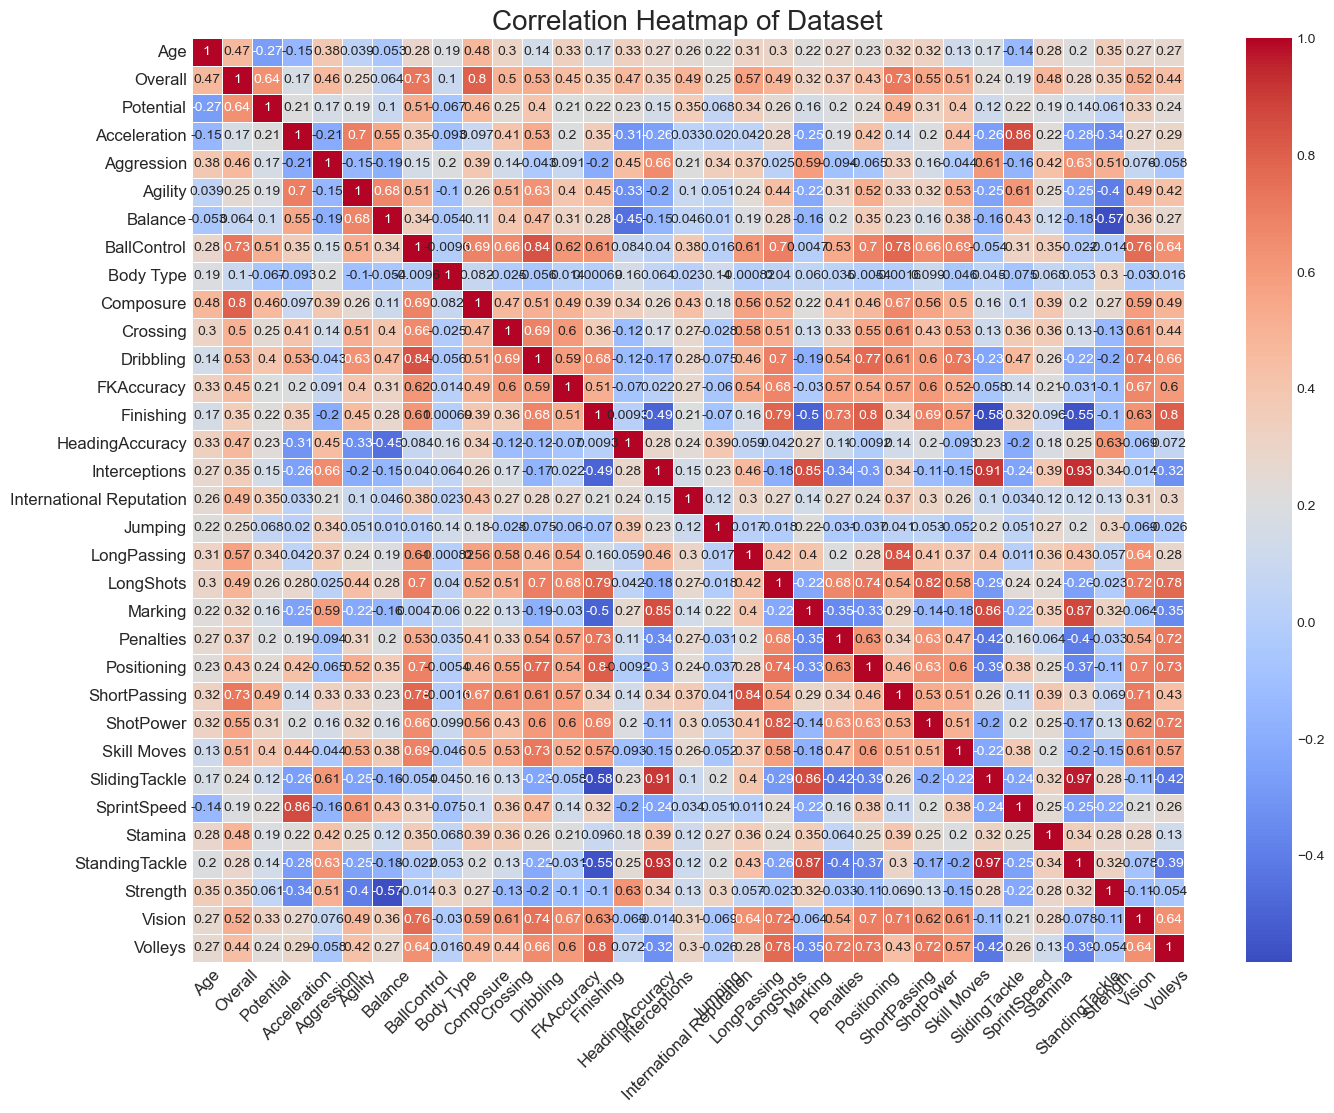

In [45]:
# Correlation heatmap
plt.rcParams['figure.figsize']=(16,12)
plt.style.use('seaborn-dark')
hm=sns.heatmap(df[['Age', 'Overall', 'Potential', 'Value', 'Wage',
                'Acceleration', 'Aggression', 'Agility', 'Balance', 'BallControl', 
                'Body Type','Composure', 'Crossing','Dribbling', 'FKAccuracy', 'Finishing', 
                'HeadingAccuracy', 'Interceptions','International Reputation',
                'Joined', 'Jumping', 'LongPassing', 'LongShots',
                'Marking', 'Penalties', 'Position', 'Positioning',
                'ShortPassing', 'ShotPower', 'Skill Moves', 'SlidingTackle',
                'SprintSpeed', 'Stamina', 'StandingTackle', 'Strength', 'Vision',
                'Volleys']].corr(), annot=True, linewidths=0.5, cmap='coolwarm')
hm.set_title(label='Correlation Heatmap of Dataset', fontsize=20)
hm.tick_params(axis='both', labelsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()


#### Scatter Plot 

A <b> scatter plot </b> is a data visualization technique that displays the relationship between two variables by plotting them as points on a two-dimensional plane using Cartesian coordinates. Each axis represents one of the variables, and the position of each point on the plane is determined by the values of both variables for a single data point. Scatter plots are useful for observing the correlation between variables and identifying trends, outliers, or clusters in the data.

We defined a function make_scatter() that creates a scatter plot matrix to visualize the relationship between 'Acceleration' and a set of other features ('Agility', 'Balance', 'Dribbling', 'SprintSpeed') in the given DataFrame df. The plots include a regression line, which shows the trend between the two variables.

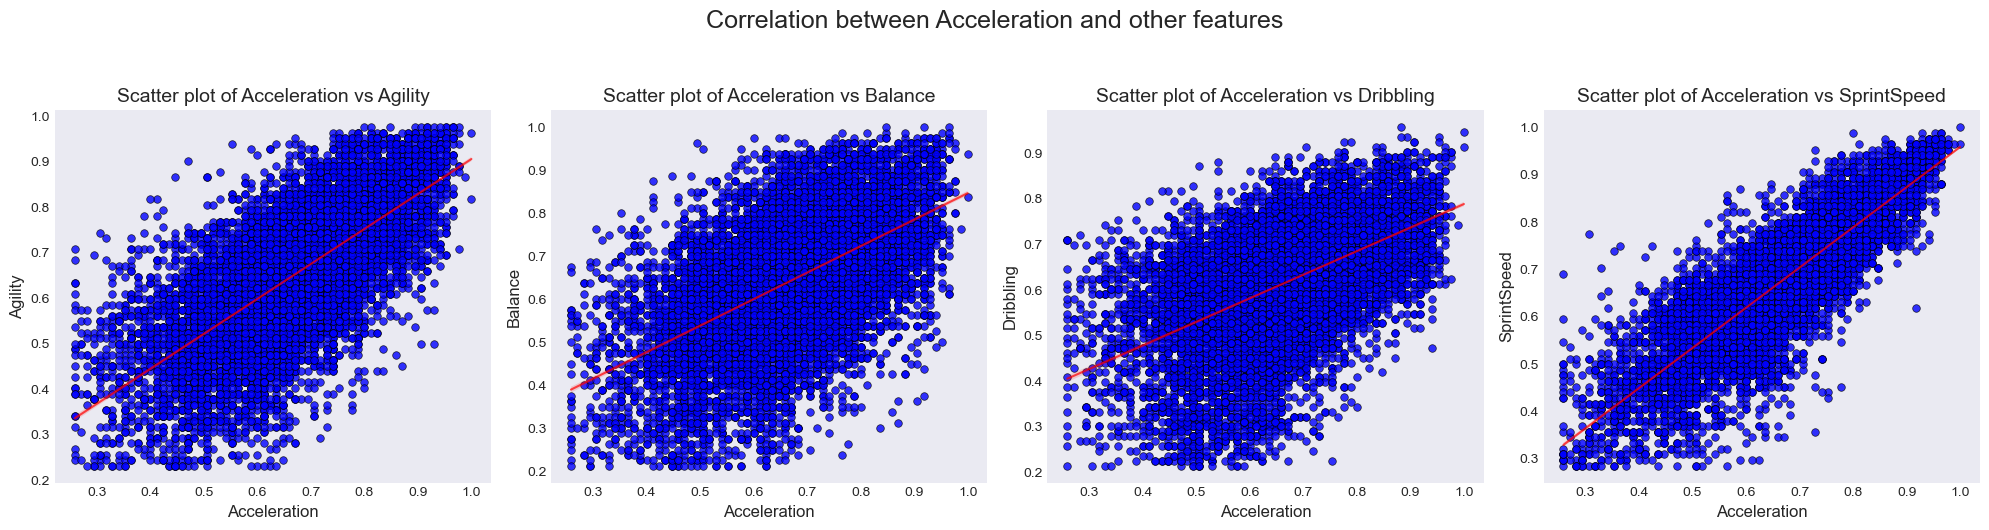

In [62]:
# Scatter plot showing correlation between Acceleration and other chosen features
def make_scatter(df):
    feats = ('Agility', 'Balance', 'Dribbling', 'SprintSpeed')
    num_plots = (len(feats) - 1) // 4 + 1
    num_cols = min(len(feats), 4)
    num_rows = (len(feats) - 1) // num_cols + 1
    
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 5*num_rows))
    
    for idx, feat in enumerate(feats):
        row = idx // num_cols
        col = idx % num_cols
        ax = axs[row, col] if num_rows > 1 else axs[col]
        sns.regplot(x='Acceleration', y=feat, data=df, color='blue', ax=ax, scatter_kws={"s": 30, "edgecolors": 'black', "linewidths": 0.5}, line_kws={"color": "red", "lw": 1.5, "alpha": 0.7})
        ax.set_xlabel('Acceleration', fontsize=12)
        ax.set_ylabel(feat, fontsize=12)
        ax.tick_params(labelsize=10)
        ax.set_title('Scatter plot of Acceleration vs ' + feat, fontsize=14)

    for ax in axs.flat[len(feats):]:
        ax.remove()

    fig.suptitle('Correlation between Acceleration and other features', fontsize=18, y=1.05)
    plt.tight_layout()
    plt.show()

make_scatter(df)


#### Histogram

A <b> histogram </b> is a data visualization technique that displays the distribution of a continuous or discrete variable by dividing the data into intervals (or bins) and representing the frequency of data points within each interval as bars. The height of the bars indicates the number of data points that fall within each bin. Histograms are useful for understanding the shape of the data distribution, identifying central tendencies, and detecting outliers or skewness.

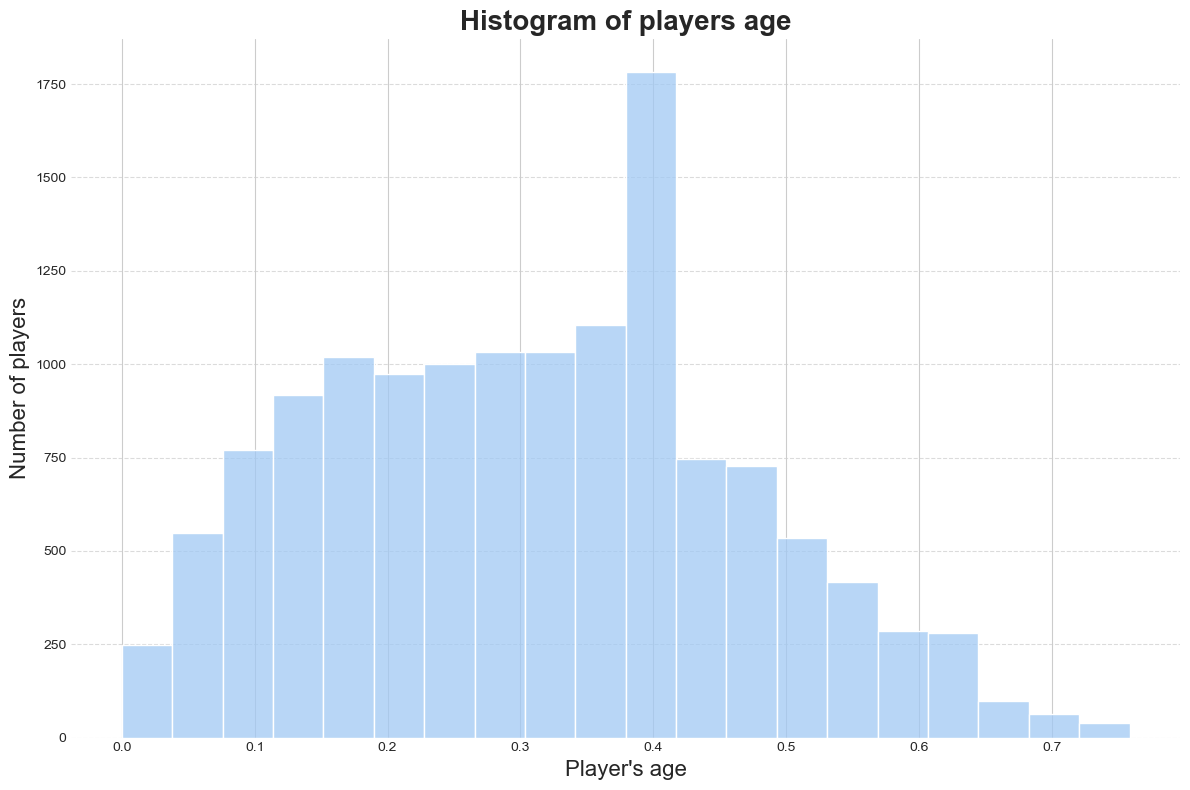

In [63]:
# Histogram: number of players' age
sns.set_style("whitegrid")
sns.set_palette("pastel")
x = df.Age
plt.figure(figsize=(12,8))
ax = sns.histplot(x, bins=20, kde=False)
ax.set_xlabel(xlabel="Player's age", fontsize=16)
ax.set_ylabel(ylabel='Number of players', fontsize=16)
ax.set_title(label='Histogram of players age', fontsize=20, fontweight='bold')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


#### Split data into training data and testing data below - 

In [64]:
X = np.array(df_x)
Y = np.array(df_y)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1 )

## Regression Models Implementation 

#### Linear Regression 

A <b> linear regression model </b> is a statistical method and machine learning algorithm used to analyze and predict the relationship between a dependent variable (target) and one or more independent variables (features). It is based on the assumption that there exists a linear relationship between the dependent and independent variables. The goal of linear regression is to find the best-fitting straight line (in the case of one independent variable) or hyperplane (in the case of multiple independent variables) that minimizes the sum of the squared differences between the actual data points and the predicted data points.

The linear regression model can be represented by the equation:

<b> y = β0 + β1 * x1 + β2 * x2 + ... + βn * xn + ε </b>

where:

<b> y </b> is the dependent variable (target).
<b> x1, x2, ..., xn </b> are the independent variables (features).
<b> β0 </b> is the intercept (the value of <b> y </b> when all independent variables are 0).
<b> β1, β2, ..., βn </b> are the coefficients (weights) associated with each independent variable, representing the strength and direction of the relationship between the independent variables and the dependent variable.
<b> ε </b> is the error term, representing the residuals or the difference between the actual and predicted values of the dependent variable.

Linear regression can be used for various purposes, such as prediction, forecasting, and understanding the relationships between variables. It is a simple yet powerful model and serves as the foundation for more complex regression techniques.

In [35]:
#Linear Regression

lr = linear_model.LinearRegression()
lr.fit(X_train,Y_train)
lr_pred = lr.predict(X_test)

print ('--------------------------------------------------')
print ('MODEL: Linear Regression')
print ('--------------------------------------------------')


print('Actual values:')
print(Y_test)
print('Predicted values:')
print(lr_pred)

lr_mse  = mean_squared_error(lr_pred, Y_test)
lr_rmse = np.sqrt(lr_mse)
print('RMSE Score for Linear Regression:', lr_mse)
print('R2 Score: %.2f' % r2_score(Y_test, lr_pred))

--------------------------------------------------
MODEL: Linear Regression
--------------------------------------------------
Actual values:
[72 68 61 ... 66 66 60]
Predicted values:
[73.10532147 67.20919999 60.64560518 ... 66.14766732 68.19920796
 60.13981655]
RMSE Score for Linear Regression: 3.1893802374980944
R2 Score: 0.93


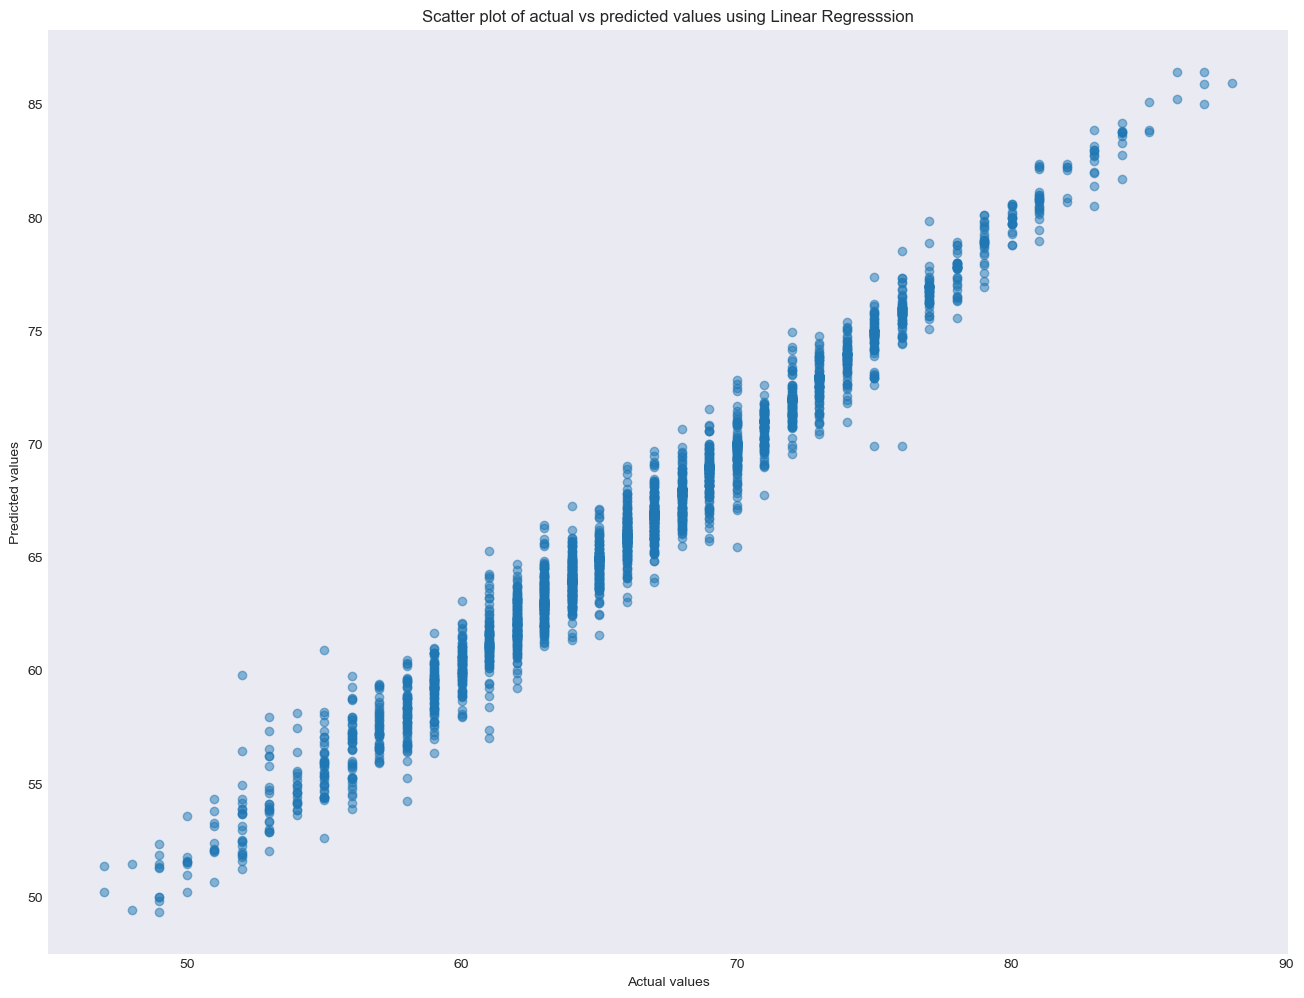

In [48]:
# Plot scatter of actual vs predicted values
plt.scatter(Y_test, lr_pred, alpha=0.5)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Scatter plot of actual vs predicted values using Linear Regresssion')
plt.show()

#### Logistic Regression

<b> Logistic regression </b> is a statistical method and machine learning algorithm used to model the relationship between a binary dependent variable (target) and one or more independent variables (features). It is an extension of linear regression, adapted for classification problems where the output variable takes on two possible classes (e.g., 0 or 1, true or false, positive or negative).
    
<b> Logistic regression </b> estimates the probability of an observation belonging to a particular class by applying a logistic (sigmoid) function to a linear combination of the independent variables. The logistic function transforms the linear combination of features into a probability value in the range of 0 to 1.

The logistic regression model can be represented by the equation:

<b> P(y=1 | x) = 1 / (1 + exp(-(β0 + β1 * x1 + β2 * x2 + ... + βn * xn))) </b>

where:

<b> P(y=1 | x) </b> is the probability of the dependent variable <b> y </b> being in class 1, given the independent variables <b> x1, x2, ..., xn </b>. 
<b> x1, x2, ..., xn </b> are the independent variables (features).
<b> β0 </b> is the intercept (the value of the log-odds when all independent variables are 0).
<b> β1, β2, ..., βn </b> are the coefficients (weights) associated with each independent variable, representing the strength and direction of the relationship between the independent variables and the log-odds of the dependent variable being in class 1.
<b> exp() </b> is the exponential function.

Logistic regression is commonly used for binary classification tasks, such as spam detection, customer churn prediction, and medical diagnosis. It can be extended to multi-class classification problems using techniques like one-vs-rest or multinomial logistic regression.


In [51]:
#Logistic Regression

lr = linear_model.LogisticRegression()
lr.fit(X_train,Y_train)
lr_pred = lr.predict(X_test)

print ('--------------------------------------------------')
print ('MODEL: Logistic Regression')
print ('--------------------------------------------------')


print('Actual values:')
print(Y_test)
print('Predicted values:')
print(lr_pred)

lr_mse  = mean_squared_error(lr_pred, Y_test)
lr_rmse = np.sqrt(lr_mse)
print('RMSE Score for Logistic Regression:', lr_mse)
print('R2 Score: %.2f' % r2_score(Y_test, lr_pred))

--------------------------------------------------
MODEL: Logistic Regression
--------------------------------------------------
Actual values:
[72 68 61 ... 66 66 60]
Predicted values:
[69 66 62 ... 61 72 60]
RMSE Score for Logistic Regression: 14.678781204111601
R2 Score: 0.66


D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


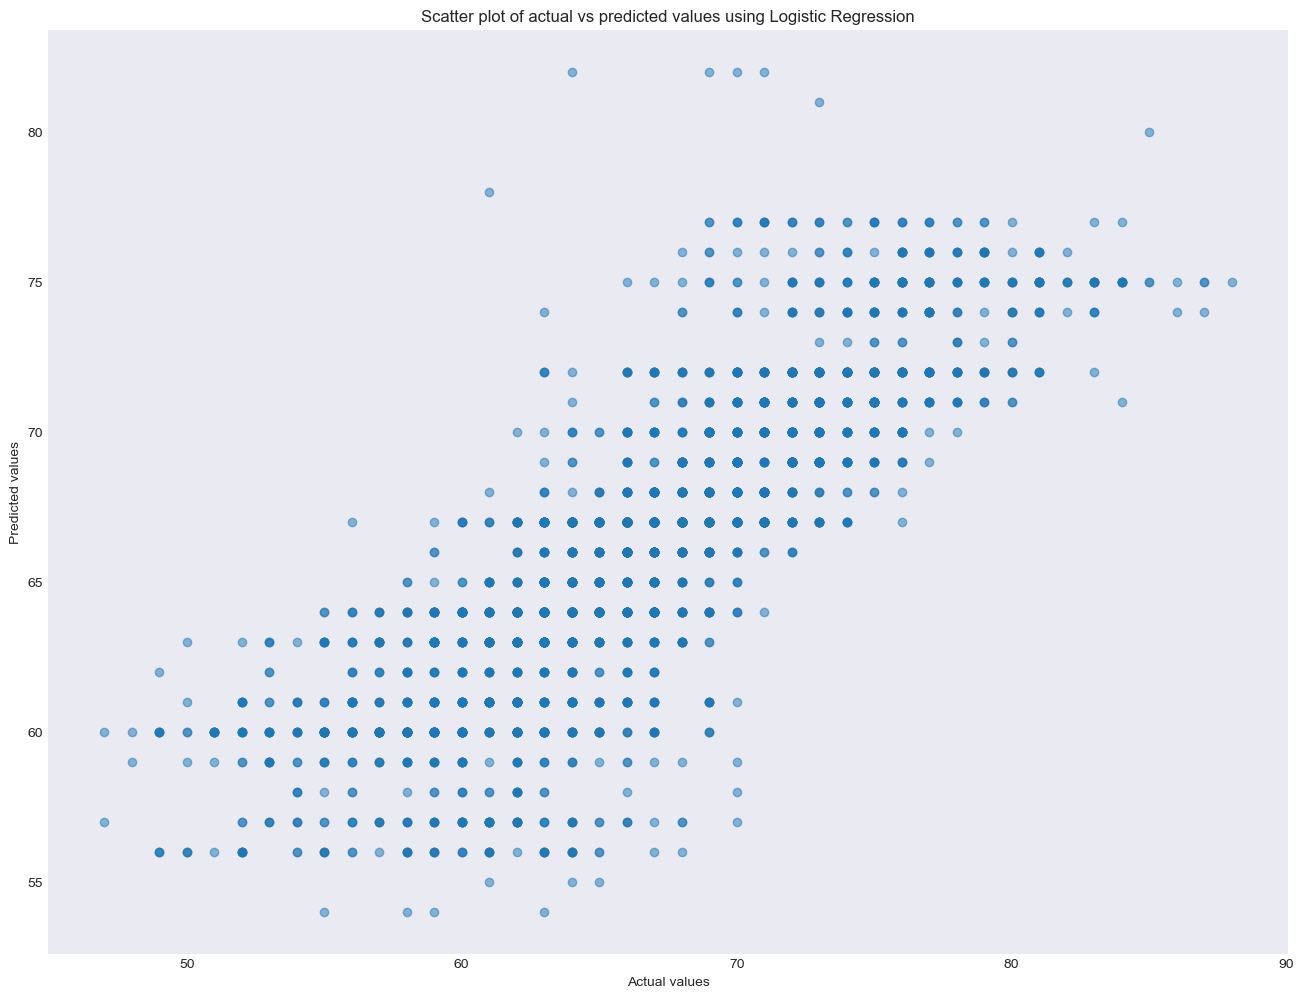

In [52]:
# Plot scatter of actual vs predicted values
plt.scatter(Y_test, lr_pred, alpha=0.5)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Scatter plot of actual vs predicted values using Logistic Regression')
plt.show()

#### K-Neighbors

The <b> k-nearest neighbors (KNN) model </b> is a non-parametric, instance-based machine learning algorithm used for both <i> classification and regression </i> tasks. It is considered <b> "lazy learning" </b> because the model does not build an explicit generalization during the training phase. Instead, it stores the training data and uses it to make predictions during the testing phase.

The KNN algorithm works by finding the k nearest data points (neighbors) to a new, unseen observation and using the majority class (for classification) or the average value (for regression) of these neighbors to predict the target value for the new observation. The distance between data points is usually measured using metrics like Euclidean, Manhattan, or Minkowski distance.

In [39]:
#K-Neighbors

lr = KNeighborsClassifier()
lr.fit(X_train,Y_train)
lr_pred = lr.predict(X_test)

print ('--------------------------------------------------')
print ('MODEL: K-Neighbors')
print ('--------------------------------------------------')


print('Actual values:')
print(Y_test)
print('Predicted values:')
print(lr_pred)

lr_mse  = mean_squared_error(lr_pred, Y_test)
lr_rmse = np.sqrt(lr_mse)
print('RMSE Score for K-Neighbors:', lr_mse)
print('R2 Score: %.2f' % r2_score(Y_test, lr_pred))

--------------------------------------------------
MODEL: K-Neighbors
--------------------------------------------------
Actual values:
[72 68 61 ... 66 66 60]
Predicted values:
[67 64 57 ... 67 68 56]
RMSE Score for K-Neighbors: 9.551027900146844
R2 Score: 0.78


D:\Anaconda\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


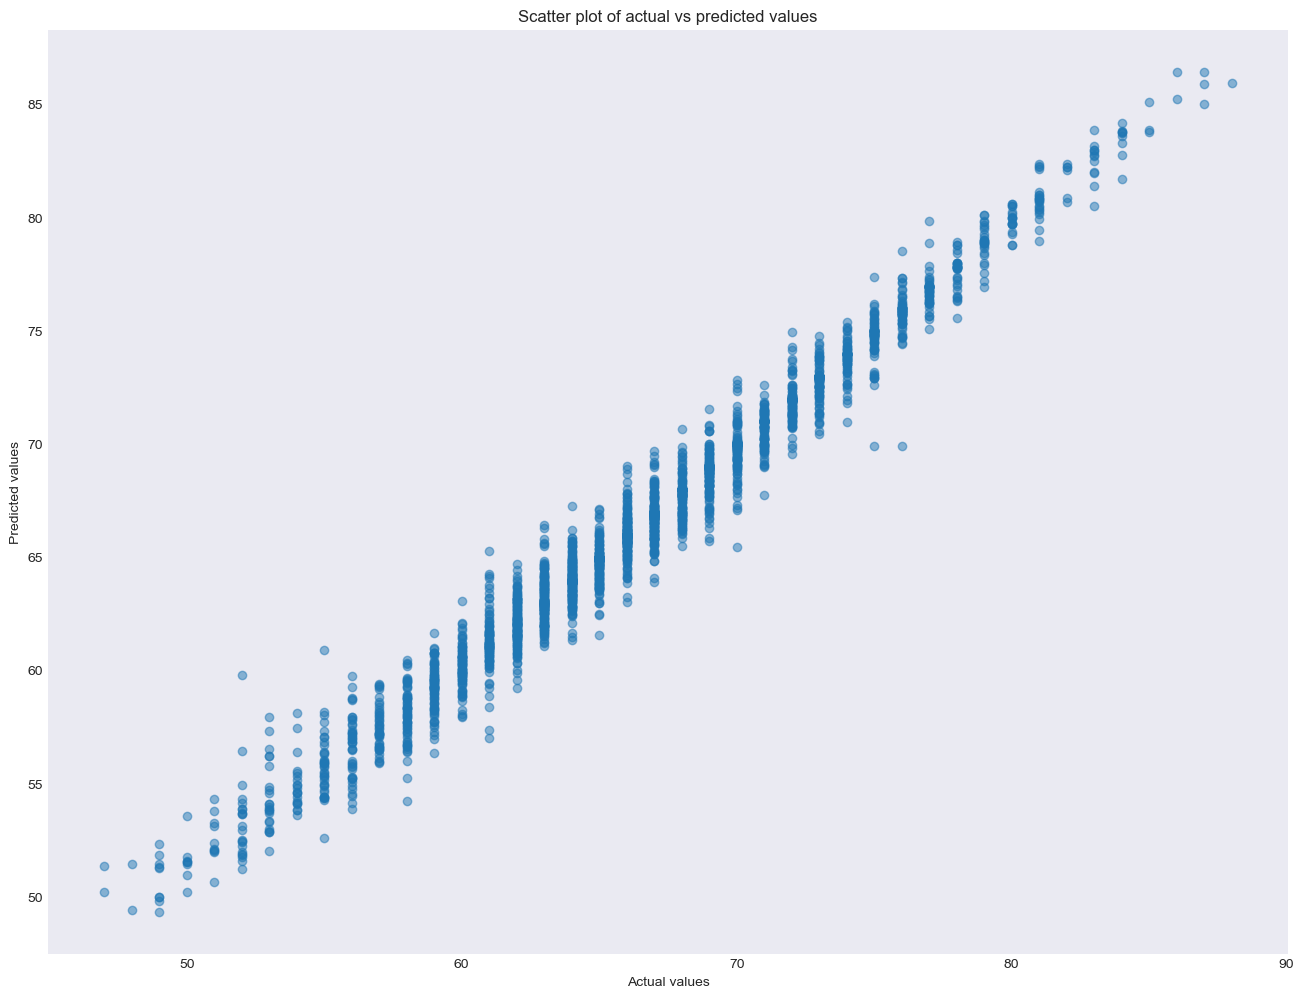

In [50]:
# Plot scatter of actual vs predicted values
plt.scatter(Y_test, lr_pred, alpha=0.5)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Scatter plot of actual vs predicted values using K-Neighbors')
plt.show()

#### Random Forest

<b> Random Forest is an ensemble learning method </b> used for both classification and regression tasks. It is based on the concept of creating multiple decision trees during the training phase and combining their results to make a final prediction. The Random Forest model improves the performance and reduces the overfitting often found in individual decision trees by averaging their predictions.

<b> RandomForestRegressor() </b> is a class in the scikit-learn library (sklearn) that provides an implementation of the Random Forest algorithm for regression tasks. It creates an ensemble of decision trees trained on random subsets of the dataset and combines their predictions to produce a more accurate and robust regression model.


In [55]:
#Random Forest 

lr = RandomForestRegressor()
lr.fit(X_train,Y_train)
lr_pred = lr.predict(X_test)

print ('--------------------------------------------------')
print ('MODEL: Random Forest')
print ('--------------------------------------------------')


print('Actual values:')
print(Y_test)
print('Predicted values:')
print(lr_pred)

lr_mse  = mean_squared_error(lr_pred, Y_test)
lr_rmse = np.sqrt(lr_mse)
print('RMSE Score for Random Forest:', lr_mse)
print('R2 Score: %.2f' % r2_score(Y_test, lr_pred))

--------------------------------------------------
MODEL: Random Forest
--------------------------------------------------
Actual values:
[72 68 61 ... 66 66 60]
Predicted values:
[71.99 67.89 61.4  ... 66.81 68.   58.31]
RMSE Score for Random Forest: 1.0589944933920707
R2 Score: 0.98


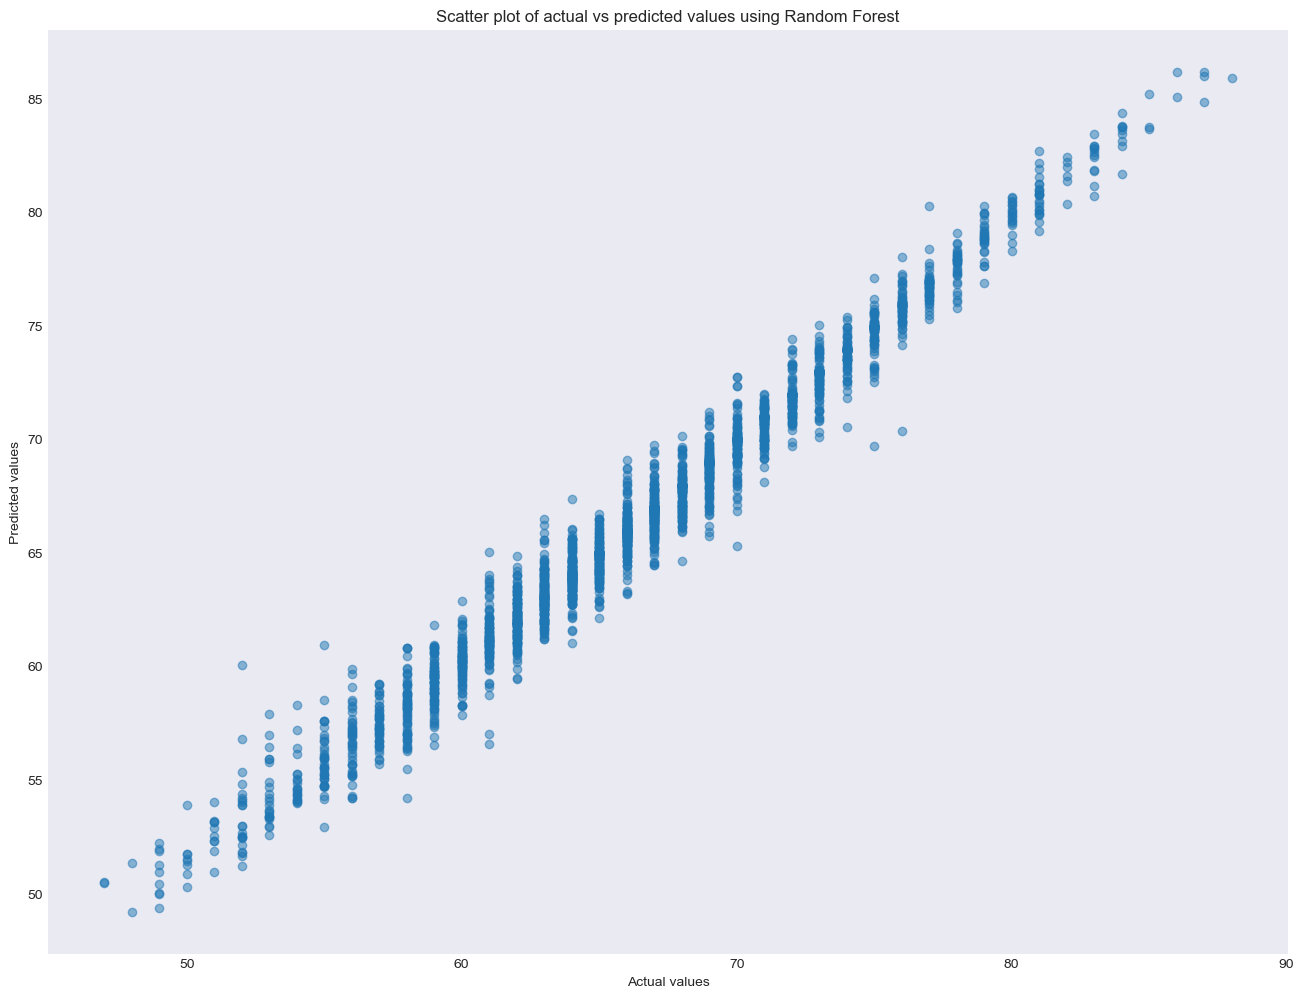

In [56]:
# Plot scatter of actual vs predicted values
plt.scatter(Y_test, lr_pred, alpha=0.5)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Scatter plot of actual vs predicted values using Random Forest')
plt.show()

#### Support Vector Machine 

<b> Support Vector Machine (SVM) </b> is a supervised machine learning algorithm primarily used for classification tasks, but it can also be adapted for regression tasks. SVM aims to find the optimal hyperplane (or decision boundary) that maximally separates the data points from different classes. It is particularly effective for high-dimensional data and can handle both linear and non-linear relationships between features and target variables.

The core concept of SVM is maximizing the margin, which is the distance between the decision boundary and the closest data points from each class, known as support vectors. SVM uses a technique called the <b> "kernel trick" </b> to transform the data into a higher-dimensional space, making it easier to find a suitable decision boundary in cases where the data is not linearly separable.

<b> Support Vector Regression (SVR) </b> is the adaptation of SVM for regression tasks. Instead of finding a decision boundary, SVR aims to fit a hyperplane that is within a specified error margin (epsilon) from the actual target values. The objective is to minimize the model's complexity while keeping the errors within the allowed margin.

<b> svm </b> is a module in the scikit-learn library (sklearn) that provides an implementation of the Support Vector Machine algorithm for both classification and regression tasks. SVC (Support Vector Classification) and SVR (Support Vector Regression) are the two main classes in the svm module.

In [58]:
#Support Vector Machine

clf = svm.SVR(kernel='linear')
clf.fit(X_train, Y_train)
svm_pred = clf.predict(X_test)

print('--------------------------------------------------')
print('MODEL: SVM')
print('--------------------------------------------------')

print('Actual values:')
print(Y_test)
print('Predicted values:')
print(svm_pred)

svm_mse = mean_squared_error(svm_pred, Y_test)
svm_rmse = np.sqrt(svm_mse)
print('RMSE Score for SVM:', svm_rmse)
print('R2 Score: %.2f' % r2_score(Y_test, svm_pred))

--------------------------------------------------
MODEL: SVM
--------------------------------------------------
Actual values:
[72 68 61 ... 66 66 60]
Predicted values:
[73.00486673 67.40077111 60.71503297 ... 66.34658629 68.48136644
 60.56409417]
RMSE Score for SVM: 1.7920072233881044
R2 Score: 0.93


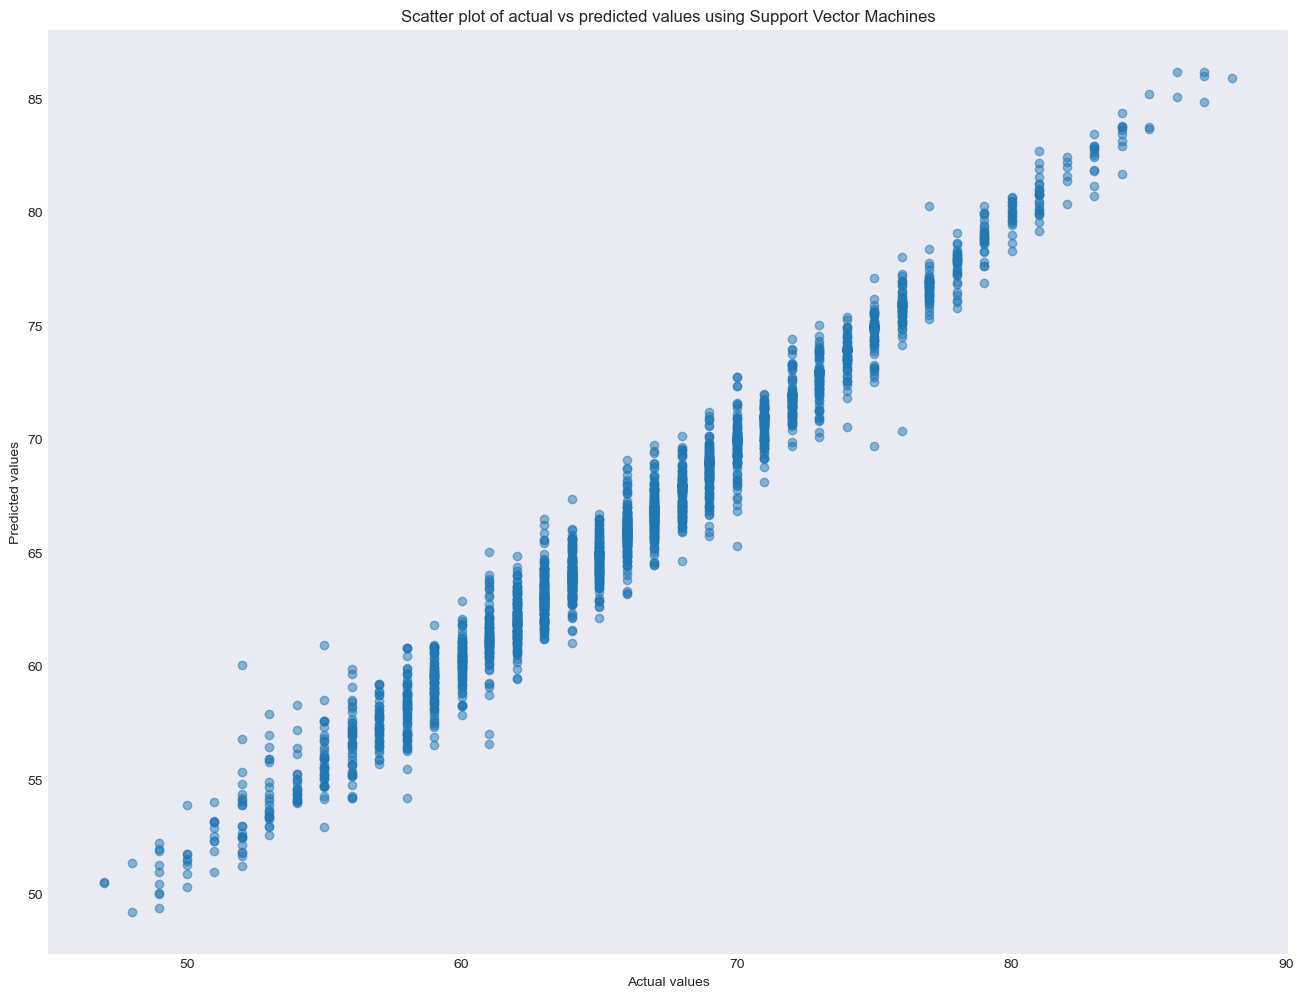

In [59]:
# Plot scatter of actual vs predicted values
plt.scatter(Y_test, lr_pred, alpha=0.5)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Scatter plot of actual vs predicted values using Support Vector Machines')
plt.show()